# Logistic regression: What affects whether you get a speeding ticket or a warning?

In 2003 and 2004, the Boston Globe published a series called [Speed Trap: Who Gets a Ticket, Who Gets a Break?](http://archive.boston.com/globe/metro/packages/tickets/). Using speeding data from Massachusetts, we'll (kind of) reproduce some segments of this analysis using logistic regression.

[Full writeup here](https://investigate.ai/boston-globe-tickets/)

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)

In [40]:
# Unknown data is always coded as 'U', so we'll pass that to na_values
df = pd.read_csv('tickets-warnings.csv',
                 na_values='U',
                 usecols=['TYPE','SEX','MINORITY', 'BLACK','ASIAN',
                          'HISPANIC','AGE','MPH','MPHOVER',
                          'INTOWN', 'INSTATE', 'DAYNIGHT'])
df.head()

,TYPE,MINORITY,BLACK,ASIAN,HISPANIC,SEX,DAYNIGHT,MPH,MPHOVER,AGE,INTOWN,INSTATE
0,T,W,0.0,0.0,0.0,M,day,80,15.0,21.0,N,Y
1,T,W,0.0,0.0,0.0,F,day,0,NaN,36.0,N,Y
2,T,W,0.0,0.0,0.0,F,day,0,NaN,61.0,N,N
3,T,W,0.0,0.0,0.0,M,night,0,NaN,52.0,N,N
4,T,W,0.0,0.0,0.0,M,day,85,20.0,24.0,N,Y


In [41]:
df.TYPE.value_counts()

T    84002
W    82366
Name: TYPE, dtype: int64

## Non-logistic analysis

In [42]:
pd.crosstab(df.MINORITY, df.TYPE)

TYPE,T,W
MINORITY,,
M,16072,12636
W,65624,68291


In [43]:
pd.crosstab(df.MINORITY, df.TYPE, normalize='index')

TYPE,T,W
MINORITY,,
M,0.559844,0.440156
W,0.490042,0.509958


<AxesSubplot:xlabel='MINORITY'>

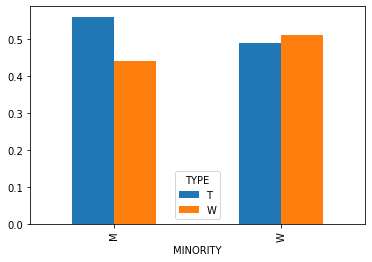

In [44]:
pd.crosstab(df.MINORITY, df.TYPE, normalize='index').plot(kind='bar')

## Logistic regression

In [45]:
df['ticketed'] = df.TYPE.replace({'T': 1, 'W': 0})
df.head()

,TYPE,MINORITY,BLACK,ASIAN,HISPANIC,SEX,DAYNIGHT,MPH,MPHOVER,AGE,INTOWN,INSTATE,ticketed
0,T,W,0.0,0.0,0.0,M,day,80,15.0,21.0,N,Y,1
1,T,W,0.0,0.0,0.0,F,day,0,NaN,36.0,N,Y,1
2,T,W,0.0,0.0,0.0,F,day,0,NaN,61.0,N,N,1
3,T,W,0.0,0.0,0.0,M,night,0,NaN,52.0,N,N,1
4,T,W,0.0,0.0,0.0,M,day,85,20.0,24.0,N,Y,1


In [46]:
model = smf.logit("""
    ticketed ~ 
        C(SEX)
        + C(MINORITY)
        + AGE
        + MPHOVER
        + C(INTOWN)
        + C(INSTATE)
        + C(DAYNIGHT)
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.607783
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ticketed   No. Observations:                89691
Model:                          Logit   Df Residuals:                    89683
Method:                           MLE   Df Model:                            7
Date:                Fri, 29 Jul 2022   Pseudo R-squ.:                  0.1217
Time:                        19:55:15   Log-Likelihood:                -54513.
converged:                       True   LL-Null:                       -62070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8051      0.043    -18.664      0.000      -0.890      -0.721
C(SEX)[T.M]              0.3260      0.015     21.726      0.000       0.297       0.355
C(MINORITY)[T.W]        -0.3967      0.022    -18.286      0.000      -0.439      -0.354
C(INTOWN)[T.Y]          -0.5611      0.018    -31.952      0.000      -0.596      -0.527
C(INSTATE)[T.Y]         -0.6323      0.022    -28.680      0.000      -0.676      -0.589
C(DAYNIGHT)[T.night]    -0.1462      0.016     -9.323      0.000      -0.177      -0.115
AGE                     -0.0158      0.001    -28.674      0.000      -0.017      -0.015
MPHOVER                  0.1574      0.002     89.697      0.000       0.154       0.161
========================================================================================
"""

In [48]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-0.805129,0.447030,Intercept
1,0.326041,1.385472,C(SEX)[T.M]
2,-0.396700,0.672536,C(MINORITY)[T.W]
3,-0.561147,0.570554,C(INTOWN)[T.Y]
4,-0.632349,0.531342,C(INSTATE)[T.Y]
5,-0.146173,0.864008,C(DAYNIGHT)[T.night]
6,-0.015810,0.984314,AGE
7,0.157402,1.170466,MPHOVER


## Reference categories

In [54]:
model = smf.logit("""
    ticketed ~ 
        C(SEX, Treatment('F'))
        + C(MINORITY, Treatment('W'))
        + AGE
        + MPHOVER
        + C(INTOWN, Treatment('Y'))
        + C(INSTATE, Treatment('Y'))
        + C(DAYNIGHT)
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.607783
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ticketed   No. Observations:                89691
Model:                          Logit   Df Residuals:                    89683
Method:                           MLE   Df Model:                            7
Date:                Fri, 29 Jul 2022   Pseudo R-squ.:                  0.1217
Time:                        19:57:10   Log-Likelihood:                -54513.
converged:                       True   LL-Null:                       -62070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -2.3953      0.037    -63.980      0.000      -2.469      -2.322
C(SEX, Treatment('F'))[T.M]          0.3260      0.015     21.726      0.000       0.297       0.355
C(MINORITY, Treatment('W'))[T.M]     0.3967      0.022     18.286      0.000       0.354       0.439
C(INTOWN, Treatment('Y'))[T.N]       0.5611      0.018     31.952      0.000       0.527       0.596
C(INSTATE, Treatment('Y'))[T.N]      0.6323      0.022     28.680      0.000       0.589       0.676
C(DAYNIGHT)[T.night]                -0.1462      0.016     -9.323      0.000      -0.177      -0.115
AGE                                 -0.0158      0.001    -28.674      0.000      -0.017      -0.015
MPHOVER                              0.1574      0.002     89.697      0.000       0.154       0.161
====================================================================================================
"""

In [55]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-2.395325,0.091143,Intercept
1,0.326041,1.385472,"C(SEX, Treatment('F'))[T.M]"
2,0.396700,1.486910,"C(MINORITY, Treatment('W'))[T.M]"
3,0.561147,1.752682,"C(INTOWN, Treatment('Y'))[T.N]"
4,0.632349,1.882026,"C(INSTATE, Treatment('Y'))[T.N]"
5,-0.146173,0.864008,C(DAYNIGHT)[T.night]
6,-0.015810,0.984314,AGE
7,0.157402,1.170466,MPHOVER
